# Comoparing 2 recordings
Goals
Whole recording comparisons
* Graph recordings and compare bandranges visually (psd and topo)
* See the difference between band ranges as a statistic
* see the difference between band range ratios as a statistic (delta/apha ration theta/alpha ratio ect.)
* make a correlation matrix between electrods and wavebands and waveband ratios

Epoch Comparisons
* reject epochs too flat / too high amplitude
* Graph recordings and compare bandranges visually (psd and topo)
* See the difference between band ranges as a statistic
* see teh difference between band range ratios as a statistic
* make a correlation matrix between electrods and wavebands and waveband ratios

# Whole recording comparisons

In [1]:
# load the recordings into pandas and clean up pandas

In [16]:
import pandas as pd
import mne

In [17]:
recordingBefore = "/Users/user/projects/museExperiments/museData/data_09-12-2003_1102/EEG_recording_2025-09-12-17.34.03.csv"
recordingAfter = "/Users/user/projects/museExperiments/museData/data_09-12-2003_1102/EEG_recording_2025-09-12-20.46.27.csv"

In [18]:
dataframeBefore = pd.read_csv(recordingBefore)
dataframeAfter = pd.read_csv(recordingAfter)

In [19]:
# dropping RightAux since it is only needed if adding costum channels and renameing the columns to match MNE
dataframeBefore = dataframeBefore.drop(["Right AUX","timestamps"], axis=1)
dataframeAfter = dataframeAfter.drop(["Right AUX", "timestamps"], axis=1)


In [20]:
# create the dataframe

In [21]:
ch_names = list(dataframeBefore.columns) # tp9 af7 af8 tp10
ch_types = ["eeg"]*len(ch_names) # 4 eeg channels
sampling_freq = 256 # muse 2 is at 256hz
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("standard_1020")
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>


In [22]:
# creating the MNE raw objects

In [23]:
rawBefore = mne.io.RawArray(dataframeBefore.values.T, info, verbose=True)  
rawAfter = mne.io.RawArray(dataframeAfter.values.T, info, verbose=True)  

Creating RawArray with float64 data, n_channels=4, n_times=14136
    Range : 0 ... 14135 =      0.000 ...    55.215 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=14136
    Range : 0 ... 14135 =      0.000 ...    55.215 secs
Ready.


In [24]:
# implementing ICA 
from mne.preprocessing import ICA
ica_before = ICA(n_components=4, random_state=42, max_iter=800)
ica_before.fit(rawBefore)
ica_after = ICA(n_components=4, random_state=42, max_iter=800)
ica_after.fit(rawAfter)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.0s.
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.0s.


/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_2616/962003074.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_before.fit(rawBefore)
/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_2616/962003074.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_after.fit(rawAfter)


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,10 iterations on raw data (14136 samples)
ICA components,4
Available PCA components,4
Channel types,eeg
ICA components marked for exclusion,—


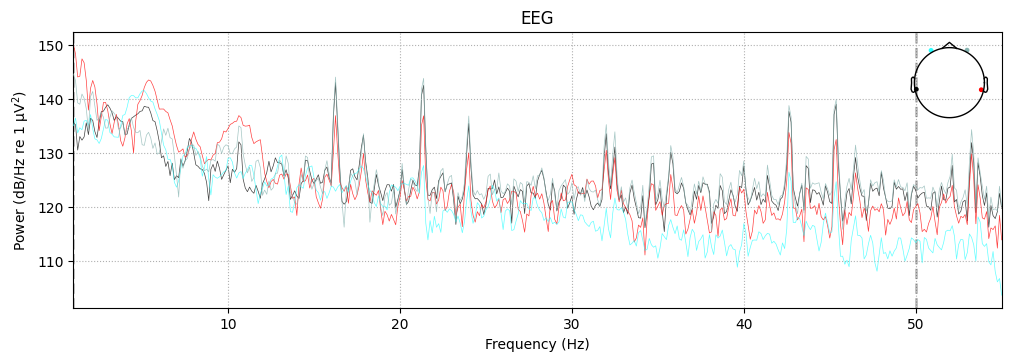

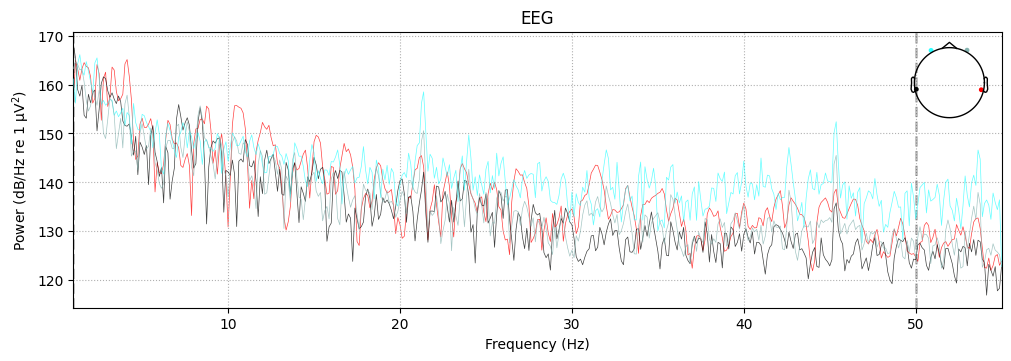

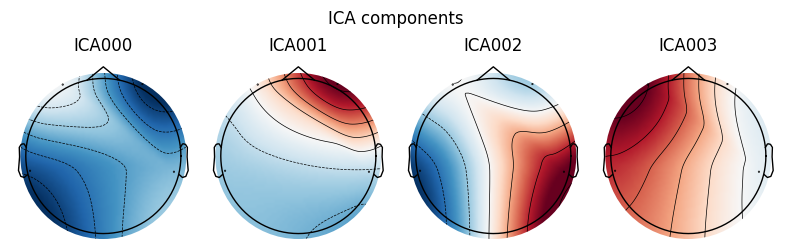

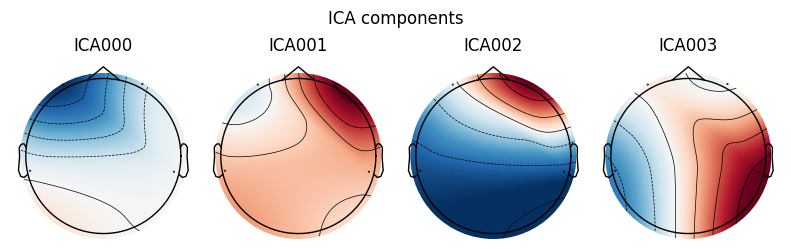

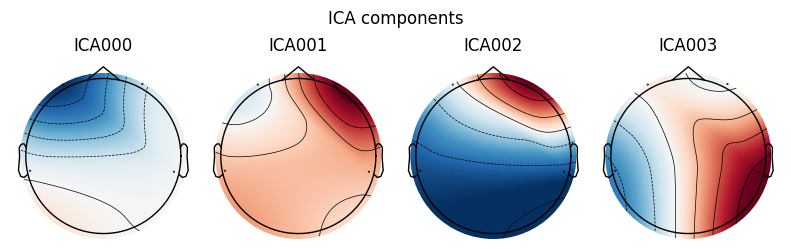

In [25]:
ica_before.plot_components() 
ica_after.plot_components() 

How to do ICA ... 
* There are artifacts and red means that ht eartifact was read by the compnent and blue means that it wasn't read by the component
* We can plot the ICA signal liek
ica_before.plot_sourecs(rawBefore)
ica_before.plot_components(rawBefore)

* if we think that ica 001 is an eyeblink since its at the front we can remove it with ica_before.exclude = [1]
* We can then apply it to the raw data liek this ... raw_clean=ica_before.apply(rawBefore.copy())

Creating RawArray with float64 data, n_channels=4, n_times=14136
    Range : 0 ... 14135 =      0.000 ...    55.215 secs
Ready.


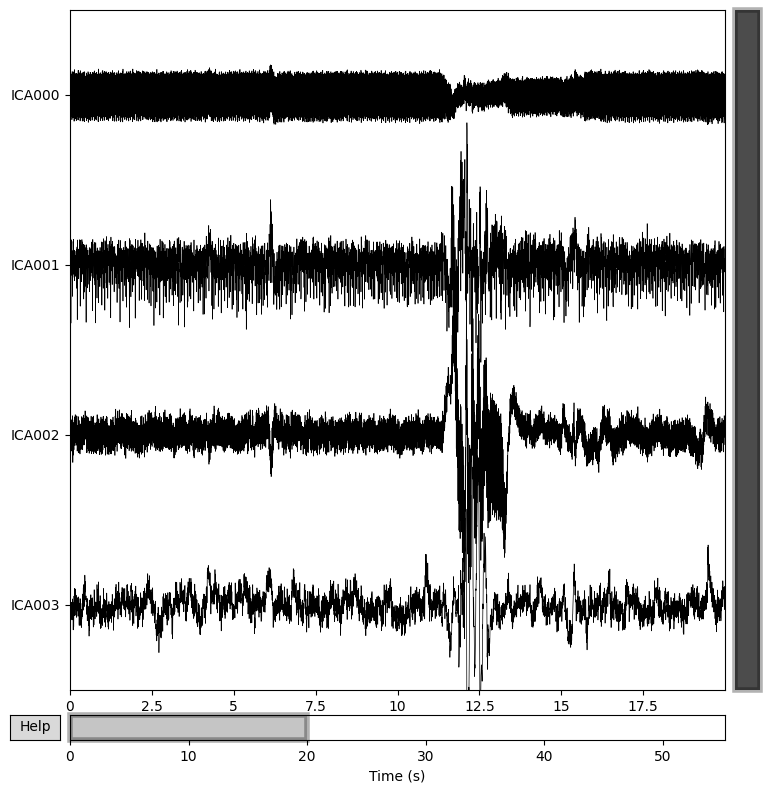

Creating RawArray with float64 data, n_channels=4, n_times=14136
    Range : 0 ... 14135 =      0.000 ...    55.215 secs
Ready.


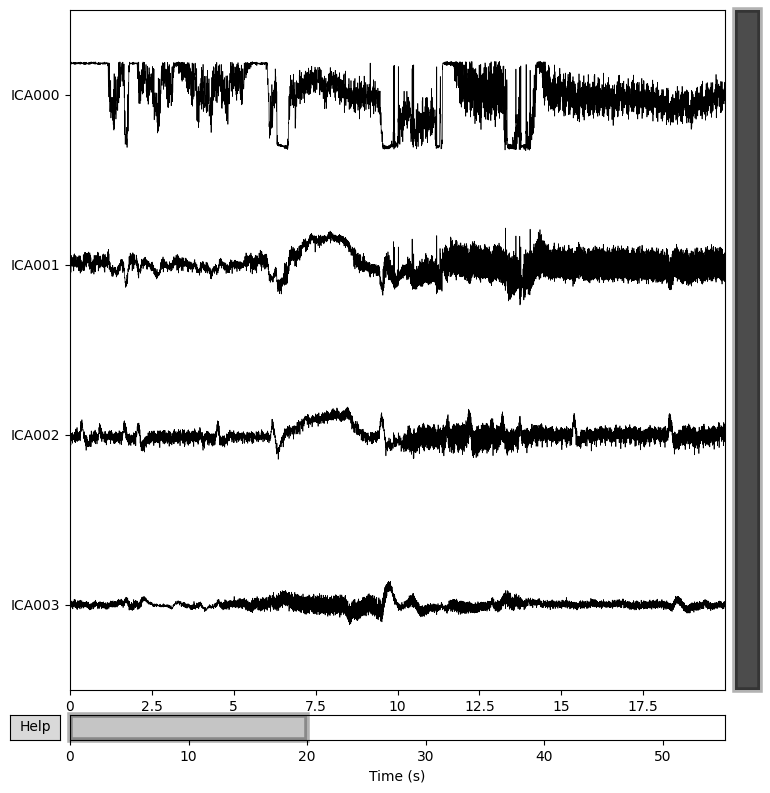

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


In [26]:
# 1. Manually inspect (e.g., plot sources for ICA)
ica_before.plot_sources(rawBefore)  # Helps spot artifacts (blinks, muscle...)
ica_after.plot_sources(rawAfter)  # Helps spot artifacts (blinks, muscle...)

# 2. Suppose you identify component 1 as artifact (e.g., eyeblink)
ica_before.exclude = [1]  # Mark component 1 to be removed
ica_after.exclude = [1]  # Mark component 1 to be removed
# ica_before.exclude = [1, 3]  # can also do a list like this

# 3. Apply to raw data to get cleaned data
rawBefore_clean = ica_before.apply(rawBefore.copy())  # Applies exclusion in-place
rawAfter_clean = ica_after.apply(rawAfter.copy())  # Applies exclusion in-place

In [27]:
rawBefore = rawBefore_clean
rawAfter = rawAfter_clean

In [28]:
# Doing analysis on the raw MNE object 
l_freq = 1     # Lower cutoff (Muse is not good below 1 Hz)
h_freq = 50    # Upper cutoff (for clean gamma, avoids muscle/noise)
# note the total cuttoff is 128hz but after 50hz its mostly noise/muslce artifacts
rawBefore.filter(l_freq=l_freq, h_freq=h_freq)  # In-place bandpass filter
rawAfter.filter(l_freq=l_freq, h_freq=h_freq)  # In-place bandpass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 5

<RawArray | 4 x 14136 (55.2 s), ~454 KiB, data loaded>

# Graphing PSD and topomap

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/anaconda3/envs/muselsl/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


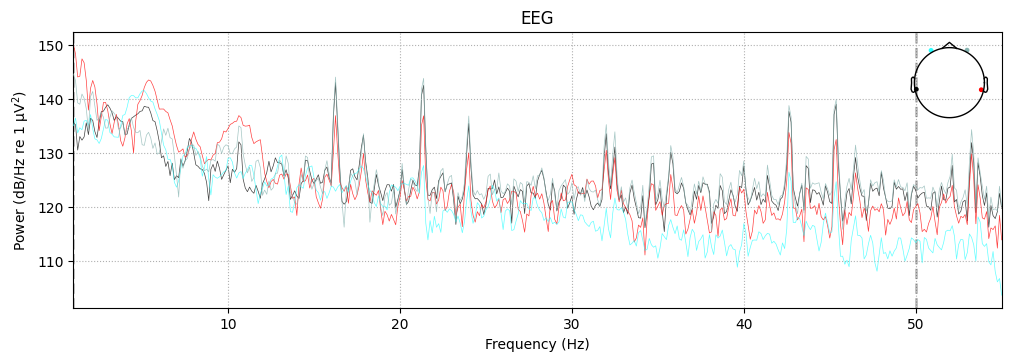

In [29]:
rawBefore.compute_psd(fmin=l_freq, fmax=h_freq+5).plot()

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/anaconda3/envs/muselsl/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


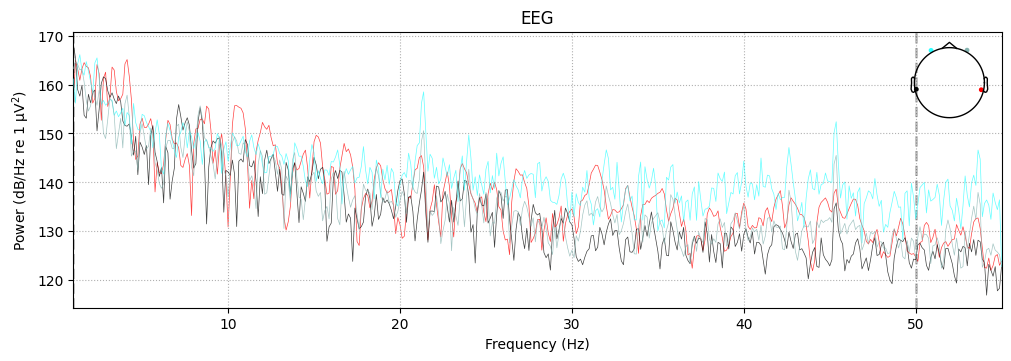

In [30]:
rawAfter.compute_psd(fmin=l_freq, fmax=h_freq+5).plot()

Effective window size : 8.000 (s)


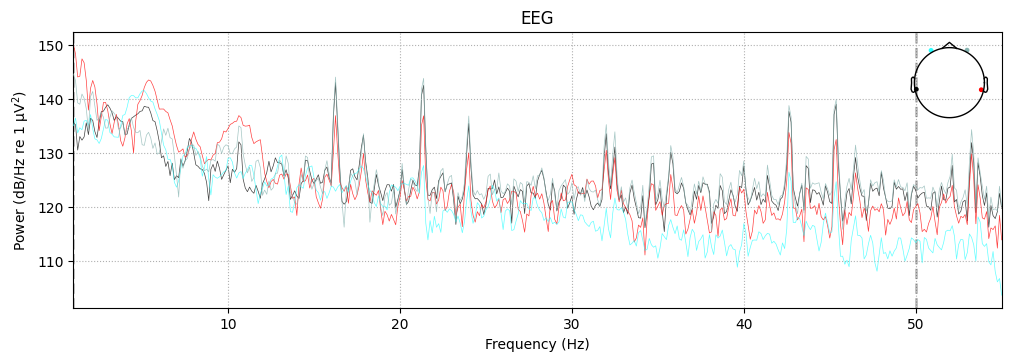

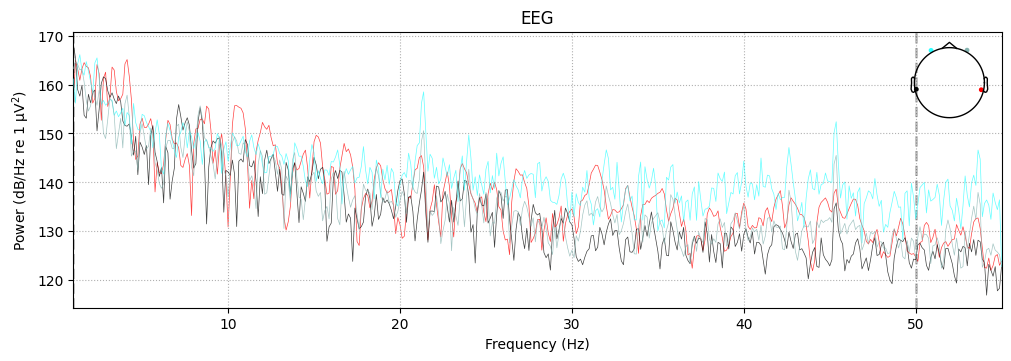

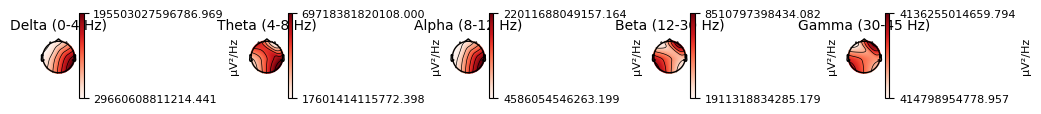

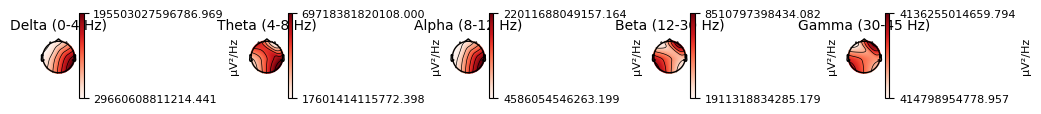

In [31]:
rawBefore.compute_psd(fmin=l_freq, fmax=h_freq+5).plot_topomap()

Effective window size : 8.000 (s)


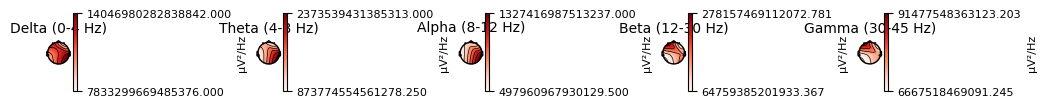

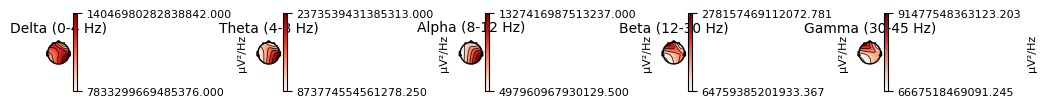

In [32]:
rawAfter.compute_psd(fmin=l_freq, fmax=h_freq+5).plot_topomap()

# Doing Epoch Analysis

In [33]:
import numpy as np

epoch_duration = 3  # seconds
sfreq = rawBefore.info['sfreq']
n_samples = int(epoch_duration * sfreq)

def make_epochs(
    raw,
    epoch_duration=3,
    max_ptp=None,     # Maximum allowed PTP amplitude in μV, e.g., 800
    min_ptp=None,     # Minimum allowed PTP amplitude in μV, e.g., 0.5
    event_id=1
):
    sfreq = raw.info['sfreq']
    n_samples = int(epoch_duration * sfreq)
    n_total_samples = raw.n_times

    # Calculate event onsets for non-overlapping epochs
    event_onsets = np.arange(0, n_total_samples - n_samples + 1, n_samples)
    events = np.column_stack((
        event_onsets,
        np.zeros_like(event_onsets),
        np.ones_like(event_onsets) * event_id
    ))

    # Set up rejection/flatness dicts for MNE, converting μV to V
    reject_dict = {'eeg': max_ptp * 1e-6} if max_ptp is not None else None
    flat_dict = {'eeg': min_ptp * 1e-6} if min_ptp is not None else None

    print(f"Making epochs: reject={reject_dict}, flat={flat_dict}")

    return mne.Epochs(
        raw,
        events,
        event_id=event_id,
        tmin=0,
        tmax=epoch_duration - 1/sfreq,
        baseline=None,
        preload=True,
        reject=reject_dict,
        flat=flat_dict
    )
epochsBefore = make_epochs(rawBefore)
epochsAfter = make_epochs(rawAfter)


Making epochs: reject=None, flat=None
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 768 original time points ...
0 bad epochs dropped
Making epochs: reject=None, flat=None
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 768 original time points ...
0 bad epochs dropped


In [34]:
psdBefore = rawBefore.compute_psd(fmin=l_freq, fmax=h_freq+5)
psdAfter = rawAfter.compute_psd(fmin=l_freq, fmax=h_freq+5)


Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


Plotting power spectral density (dB=True).


/opt/homebrew/anaconda3/envs/muselsl/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


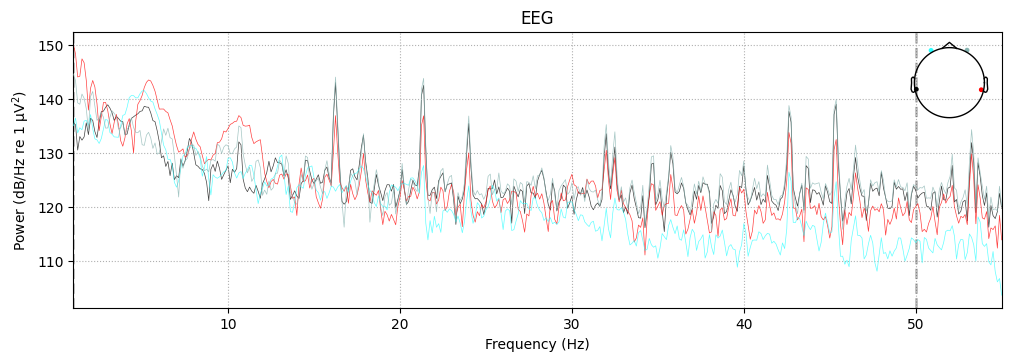

In [35]:

psdBefore.plot()


Plotting power spectral density (dB=True).


/opt/homebrew/anaconda3/envs/muselsl/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


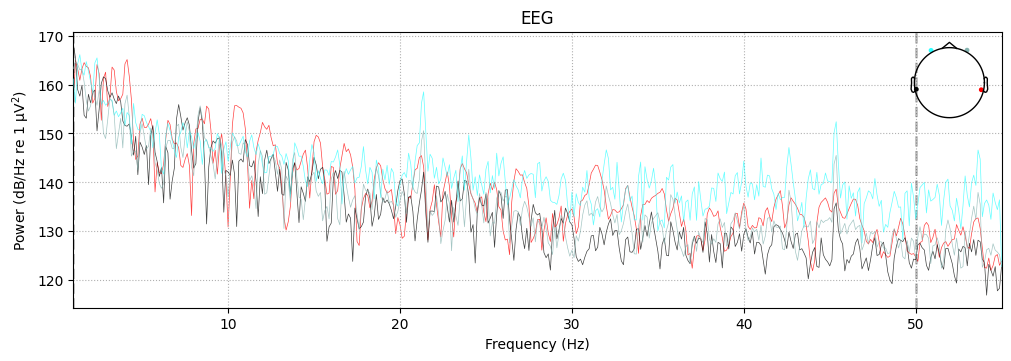

In [36]:
psdAfter.plot()

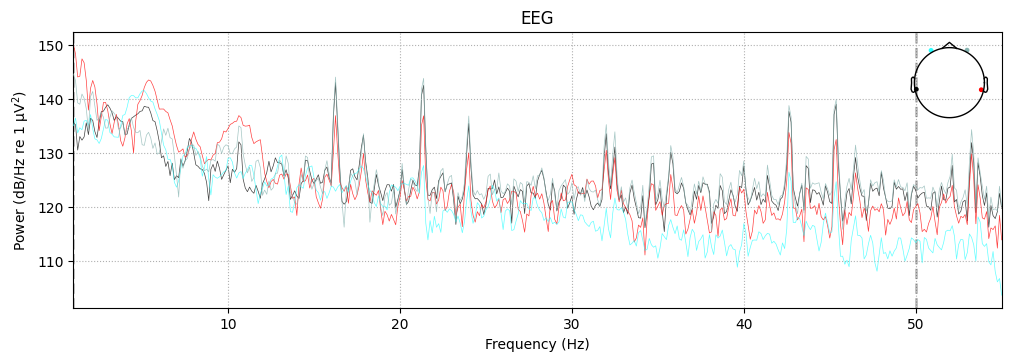

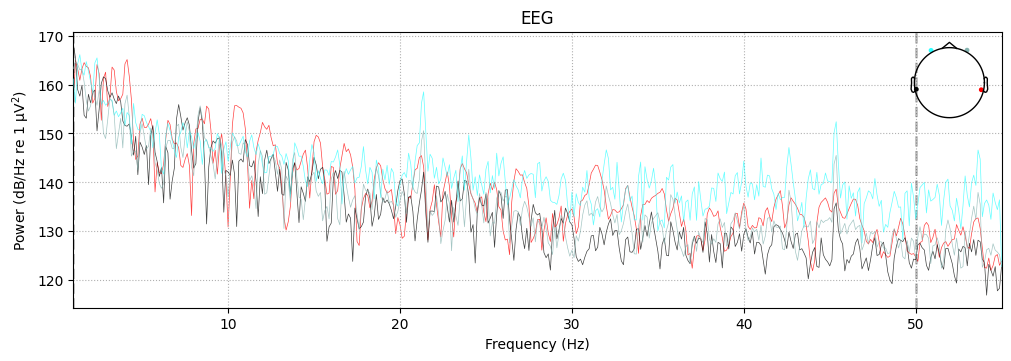

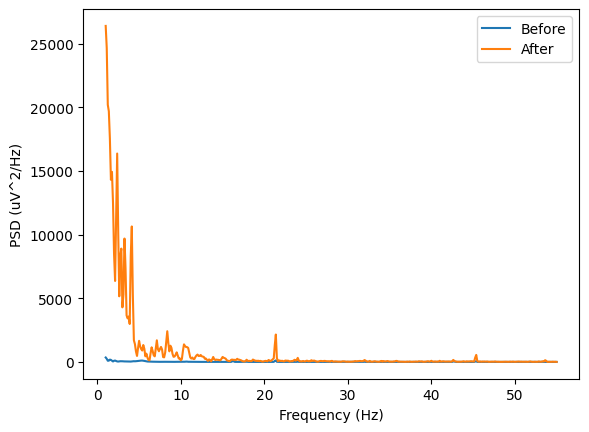

In [37]:
import matplotlib.pyplot as plt

mean_psd_before = psdBefore.get_data().mean(axis=0)  # average over channels
mean_psd_after = psdAfter.get_data().mean(axis=0)

plt.figure()
plt.plot(psdBefore.freqs, mean_psd_before, label='Before')
plt.plot(psdAfter.freqs, mean_psd_after, label='After')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (uV^2/Hz)')
plt.legend()
plt.show()


# Using MNE - features to get the features and do a deeper analysis

In [38]:
# making data using MNE-featurs

In [39]:
from mne_features.feature_extraction import FeatureExtractor
from mne_features.feature_extraction import extract_features
import numpy as np
freq_bands = np.array([0.5, 4, 8, 13, 50])

fe = FeatureExtractor(
    sfreq=epochsBefore.info['sfreq'],
    selected_funcs=['pow_freq_bands', 'energy_freq_bands', 'kurtosis'],
    params={'pow_freq_bands__freq_bands': freq_bands,
            'energy_freq_bands__freq_bands': freq_bands}
)

In [40]:
X_before = epochsBefore.get_data()
X_after  = epochsAfter.get_data()

In [41]:
features_before = fe.fit_transform(X_before)
features_after = fe.fit_transform(X_after)
print(features_before.shape)  # (n_epochs, n_features)
print(features_after.shape)

ValueError: Transformer 'pow_freq_bands' returned an array or dataframe with 1 dimensions, but expected 2 dimensions (n_samples, n_features).

In [ ]:
print("Feature names:", fe.selected_funcs)

In [ ]:
# Data analsyis 
feature_names = fe.selected_funcs

In [ ]:
# 2nd attempt - trying to get teh column names

In [ ]:
X_before = epochsBefore.get_data()  # shape: (n_epochs, n_channels, n_times)
ch_names = epochsBefore.ch_names    # e.g. ['TP9', 'AF7', 'AF8', 'TP10']

# Custom frequency bands as dict for nice labels
freq_bands = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta+gamma': [13, 50]
}

In [ ]:
selected_funcs = ['pow_freq_bands', 'energy_freq_bands', 'kurtosis']

features_before = extract_features(
    X_before,
    sfreq=epochsBefore.info['sfreq'],
    selected_funcs=selected_funcs,
    funcs_params={
        'pow_freq_bands__freq_bands': freq_bands,
        'energy_freq_bands__freq_bands': freq_bands,
    },
    ch_names=ch_names,
    return_as_df=True
)


In [ ]:
print(features_before.columns)  # MultiIndex with (feature, band, channel)
# Optional: Flatten column names
features_before.columns = ['_'.join(map(str, col)) for col in features_before.columns]
print(features_before.columns.tolist())


In [ ]:
# Do the same for after
X_after = epochsAfter.get_data()
features_after = extract_features(
    X_after,
    sfreq=epochsAfter.info['sfreq'],
    selected_funcs=selected_funcs,
    funcs_params={
        'pow_freq_bands__freq_bands': freq_bands,
        'energy_freq_bands__freq_bands': freq_bands,
    },
    ch_names=ch_names,
    return_as_df=True
)
features_after.columns = ['_'.join(map(str, col)) for col in features_after.columns]

# Pick your feature of interest (e.g., alpha power in AF7)
col = 'pow_freq_bands_AF7_alpha'

import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])
plt.ylabel('Alpha Power (AF7)')
plt.title('Alpha Power in AF7: Before vs After')
plt.show()


In [ ]:
all_feature_columns = features_before.columns.tolist()

for col in all_feature_columns:
    plt.figure(figsize=(5, 3))
    plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])
    plt.ylabel(col)
    plt.title(f'{col}: Before vs After')
    plt.tight_layout()
    plt.show()


# now doing a correlation Matrix

In [39]:
corr_before = features_before.corr()
corr_after = features_after.corr()


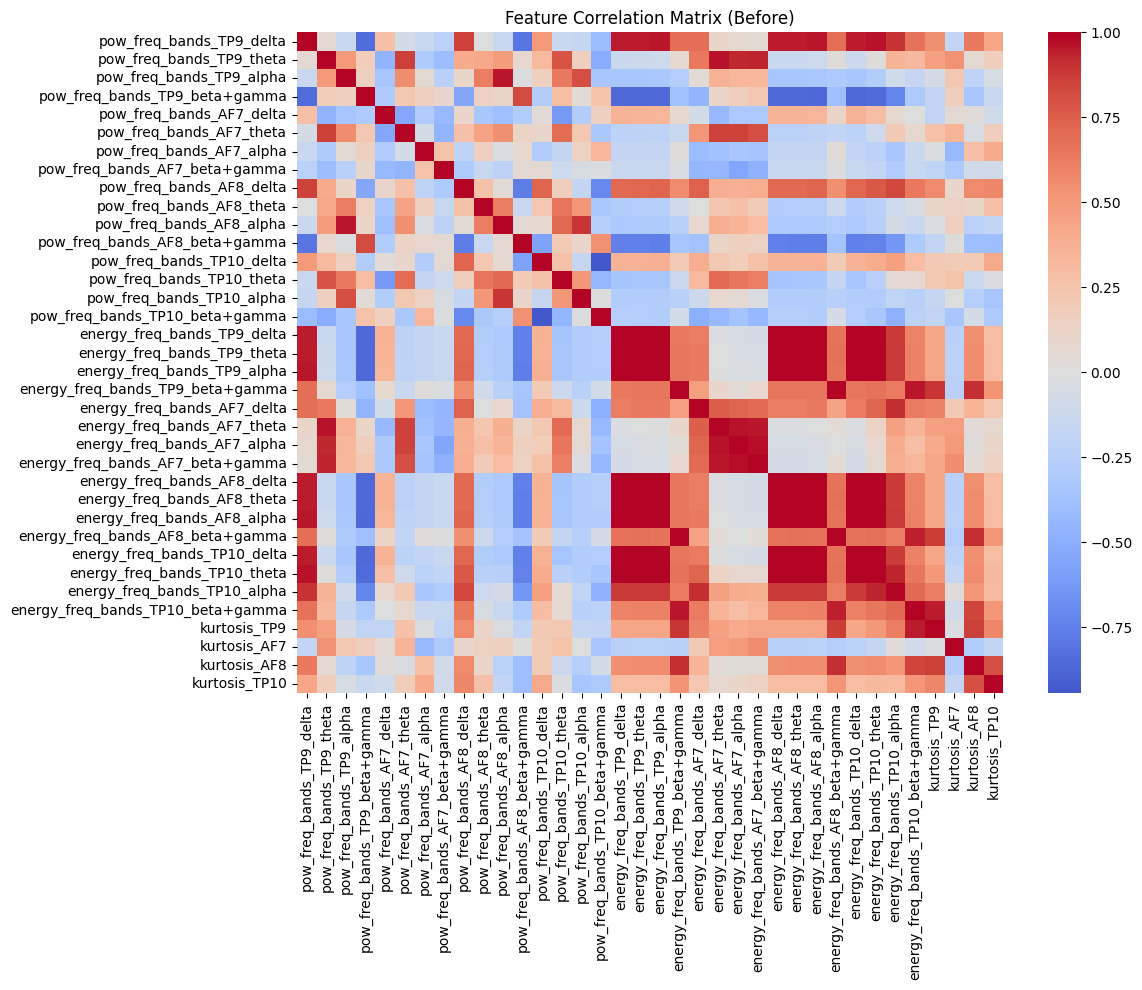

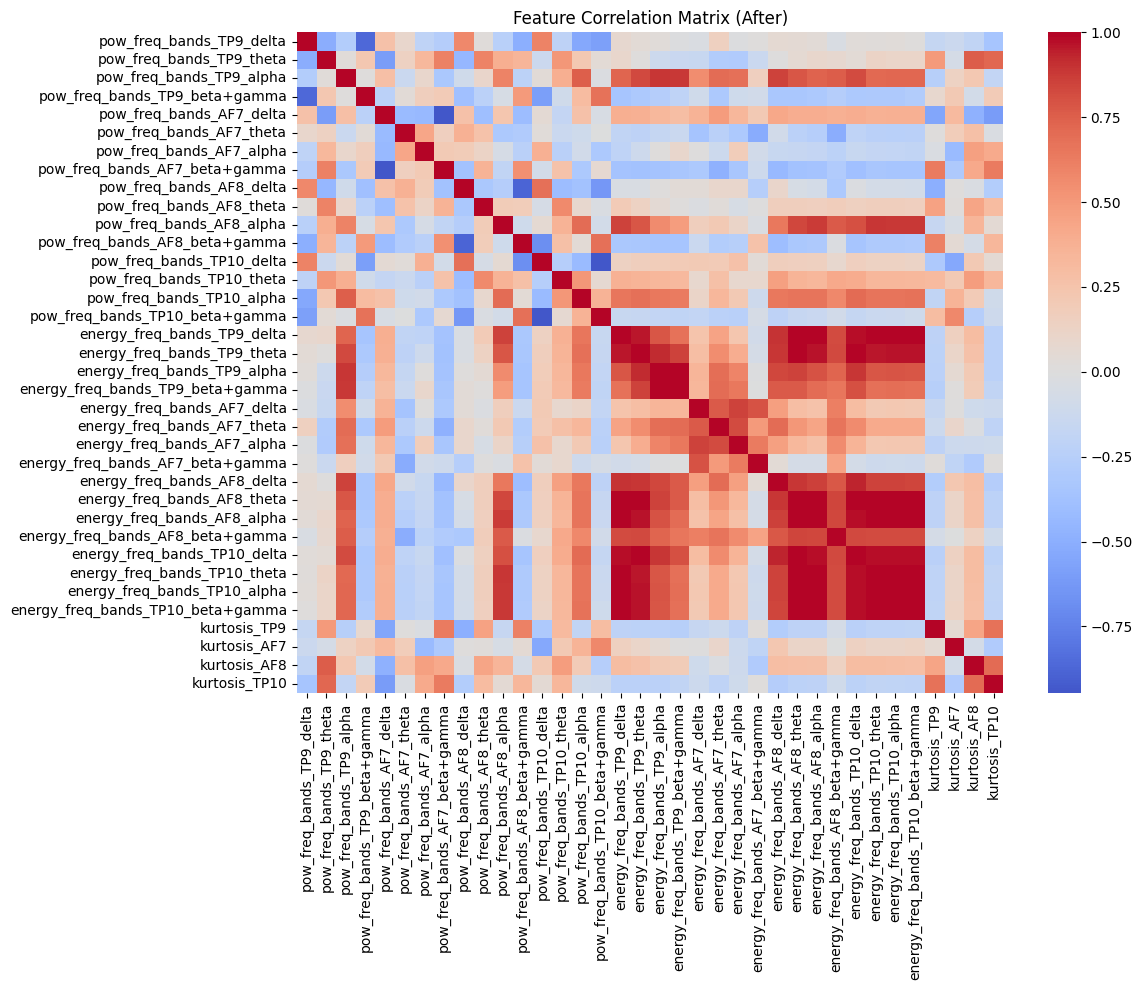

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_before, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix (Before)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(corr_after, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix (After)')
plt.tight_layout()
plt.show()


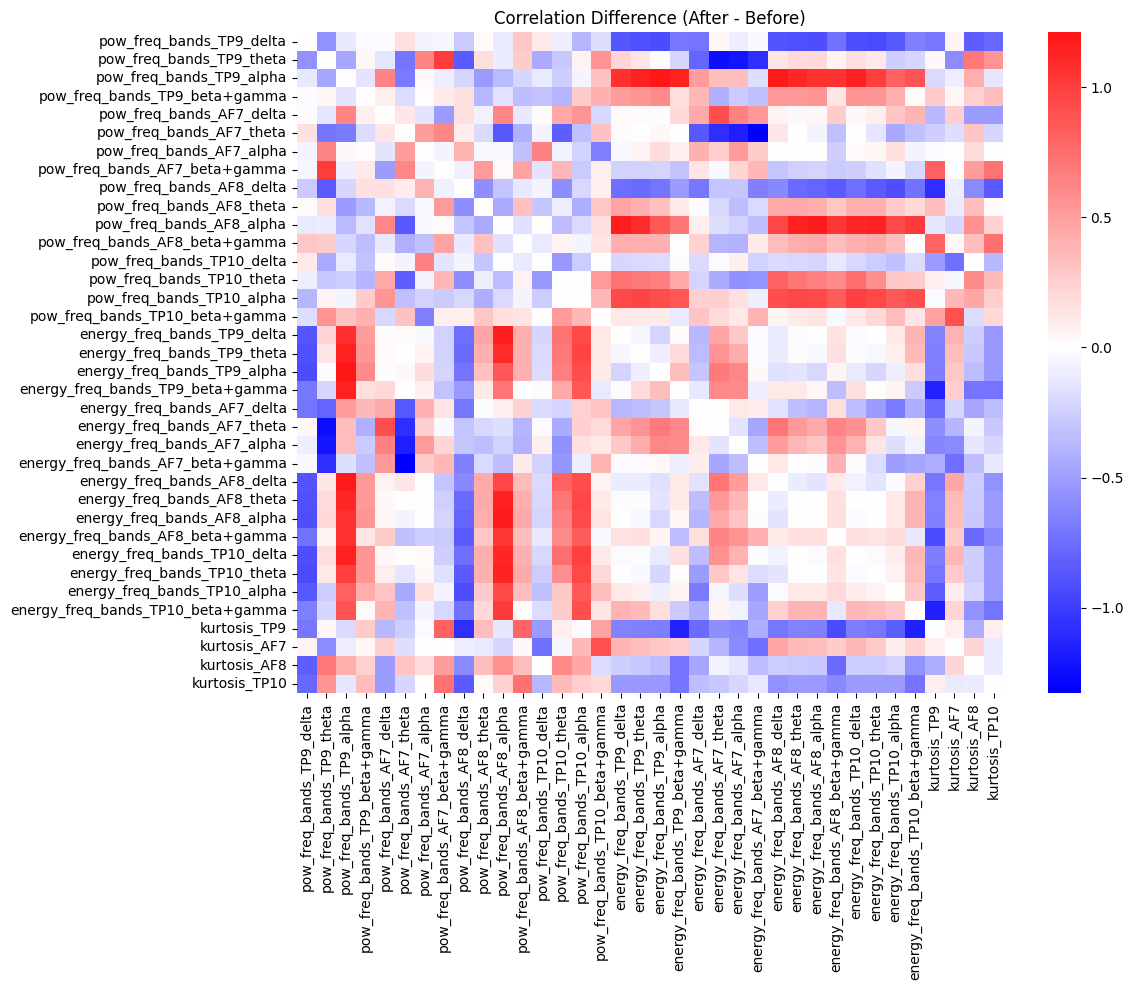

In [41]:
# subtract or plot the difference between the correlation matrices
corr_diff = corr_after - corr_before
plt.figure(figsize=(12,10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title('Correlation Difference (After - Before)')
plt.tight_layout()
plt.show()


# Clustering

In [42]:
import pandas as pd
import numpy as np

# Combine features from both groups
X = pd.concat([features_before, features_after], ignore_index=True)
group_labels = np.array(['Before'] * len(features_before) + ['After'] * len(features_after))


In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


In [45]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


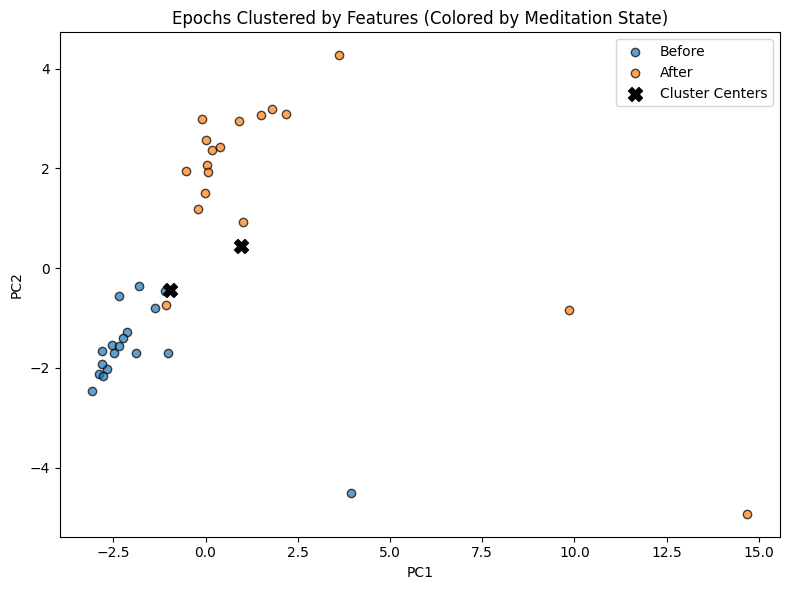

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Color by true group, not cluster!
colors = ['#1f77b4' if label == 'Before' else '#ff7f0e' for label in group_labels]

plt.figure(figsize=(8,6))
for group, color in zip(['Before', 'After'], ['#1f77b4', '#ff7f0e']):
    mask = group_labels == group
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=group, alpha=0.7, edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Epochs Clustered by Features (Colored by Meditation State)')
plt.legend()
plt.tight_layout()

# code start to show cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', s=100, marker='X', label='Cluster Centers')
plt.legend()
# code end to show cluster centers

plt.show()


# Final ... Cohen test

# Final - Cohen Test

In [47]:
import numpy as np
import pandas as pd

def cohens_d(x, y):
    # x: before, y: after
    nx = len(x)
    ny = len(y)
    s1 = np.var(x, ddof=1)
    s2 = np.var(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1)*s1 + (ny - 1)*s2) / (nx + ny - 2))
    d = (np.mean(y) - np.mean(x)) / pooled_std
    return d

# For all features:
cohen_d_results = {}
for col in features_before.columns:
    cohen_d_results[col] = cohens_d(features_before[col], features_after[col])

# Sort by magnitude (largest effect size first)
cohen_d_sorted = pd.Series(cohen_d_results).sort_values(key=np.abs, ascending=False)

print(cohen_d_sorted)


pow_freq_bands_TP9_delta             5.627232
pow_freq_bands_AF8_delta             3.600933
pow_freq_bands_TP9_beta+gamma       -2.549393
pow_freq_bands_TP10_delta            2.291350
pow_freq_bands_AF8_theta             2.207199
pow_freq_bands_AF7_alpha            -1.455354
pow_freq_bands_TP9_theta             1.245771
pow_freq_bands_AF7_theta            -1.233970
energy_freq_bands_AF7_delta          1.108867
energy_freq_bands_AF7_beta+gamma     1.040663
energy_freq_bands_AF8_beta+gamma     1.016095
energy_freq_bands_AF7_theta          0.982481
pow_freq_bands_AF7_delta             0.893953
kurtosis_AF7                        -0.848446
energy_freq_bands_AF7_alpha          0.759328
pow_freq_bands_TP9_alpha             0.731229
pow_freq_bands_TP10_beta+gamma      -0.701513
pow_freq_bands_AF8_alpha             0.584173
pow_freq_bands_TP10_theta            0.537409
pow_freq_bands_AF8_beta+gamma       -0.520906
energy_freq_bands_TP10_beta+gamma    0.518081
energy_freq_bands_TP10_alpha      

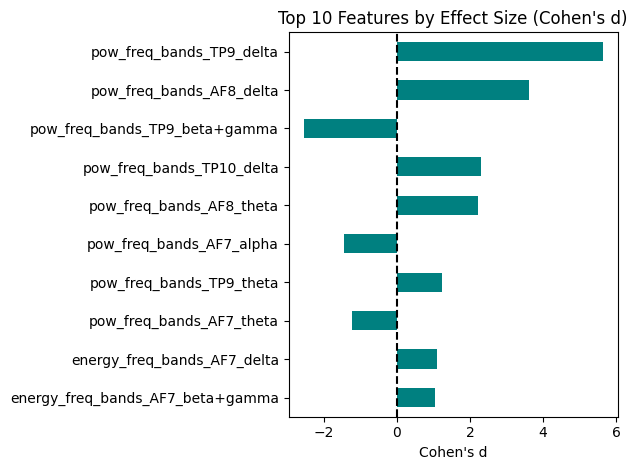

In [48]:
import matplotlib.pyplot as plt

top_n = 10
cohen_d_sorted[:top_n].plot(kind='barh', color='teal')
plt.axvline(0, color='k', linestyle='--')
plt.title(f'Top {top_n} Features by Effect Size (Cohen\'s d)')
plt.xlabel('Cohen\'s d')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
